# A model for predicting incremental diameter growth

Here we will adapt the basic diameter growth model for large trees from the Forest Vegetation Simulator into a aggregates monthly predictions of diameter growth over arbitrary periods of one or more months. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import jax
from jax import numpy as jnp
from jax import random, jit
from jax.lax import scan
from functools import partial

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_feasible
from numpyro.infer.reparam import LocScaleReparam
import arviz as az

import pandas as pd
import geopandas as gpd

In [2]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(40)

In [3]:
class DiameterGrowth():
    def __init__(self, species, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, bark_ratio1, bark_ratio2):
        self.spp = species
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.b3 = b3
        self.b4 = b4
        self.b5 = b5
        self.b6 = b6
        self.b7 = b7
        self.b8 = b8
        self.b9 = b9
        self.b10 = b10
        self.b11 = b11
        self.b12 = b12
        self.b13 = b13
        self.bark1 = bark_ratio1
        self.bark2 = bark_ratio2
    
    def grow(self, dbh, site_index, asp, slope, elev, 
             crown_ratio, comp_tree, comp_stand, num_steps,
             crown_ratio_end = None, comp_tree_end = None,
             comp_stand_end = None):
        
        dbh = jnp.asarray(dbh).reshape(-1,)
        num_trees = dbh.size
        site_index = jnp.asarray(site_index).reshape(-1,)
        asp = jnp.asarray(asp).reshape(-1,)
        slope = jnp.asarray(slope).reshape(-1,)
        elev = jnp.asarray(elev).reshape(-1,)
        site_index = jnp.full((num_steps, num_trees), site_index)
        asp = jnp.full((num_steps, num_trees), site_index) 
        slope = jnp.full((num_steps, num_trees), slope)
        elev = jnp.full((num_steps, num_trees), elev)
        
        if crown_ratio_end is not None:
            cr = jnp.linspace(crown_ratio, crown_ratio_end, num_steps)
        else:
            cr = jnp.full((num_steps, num_trees), crown_ratio)
        
        if comp_tree_end is not None:
            comp_tree = jnp.linspace(comp_tree, comp_tree_end, num_steps)
        else:
            comp_tree = jnp.full((num_steps, num_trees), comp_tree)
        
        if comp_stand_end is not None:
            comp_stand = jnp.linspace(comp_stand, comp_stand_end, num_steps)
        else:
            comp_stand = jnp.full((num_steps, num_trees), comp_stand)
            
        covars = site_index, asp, slope, elev, cr, comp_tree, comp_stand
        
        def step(dbh, covars):
            site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand = covars

            size = self.b1 * jnp.log(dbh) + self.b2 * (dbh**2)
            site = self.b3 * jnp.log(site_index) + \
                   self.b4 * (slope * jnp.cos(asp)) + self.b5 * (slope * jnp.sin(asp)) + \
                   self.b6 * slope + self.b7 * slope**2 + \
                   self.b8 * elev + self.b9 * elev ** 2
            comp = self.b10 * crown_ratio + self.b11 * crown_ratio**2 + \
                   self.b12 * comp_tree + self.b13 * comp_stand
            ln_dds = self.b0 + size + site + comp

            dds = jnp.exp(ln_dds)

            dib_start = self.bark1*(dbh**self.bark2)
            dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
            dib_end = dib_start + dg_ib
            dbh_end = (dib_end / self.bark1)**(1/self.bark2)
            dg_ob = dbh_end - dbh

            return dbh_end, dg_ob
    
        # scan returns arrays of final dbh (shape: (n_trees,)) 
        # and of incremental growth (shape: (n_steps, n_trees))
        end_dbhs, growth = scan(step, dbh, covars, length=num_steps)       

        # return ending dbh for each tree, as well as incremental outside-bark diameter growth
        return end_dbhs, growth
        # return covars

In [4]:
DF_PN_COEFS = dict(  # 5-year coefs
    b0 = -0.739354,    # intercept
    b1 = 0.80,    # ln(dbh)
    b2 = -0.0000896,  # dbh**2
    b3 = 0.49,    # ln(site_index)
    b4 = 0.014165,    # slope*cos(asp)
    b5 = 0.003263,       # slope*sin(asp)
    b6 = -0.340401,    # slope
    b7 = 0,        # slope**2
    b8 = -0.009845,       # elev 
    b9 = 0,       # elev**2
    b10 = 1.936912,   # crown_ratio
    b11 = 0.,     # crown_ratio**2
    b12 = -0.001827,  # comp_tree (BAL/ln(dbh+1))
    b13 = -0.129474,   # comp_stand (lnBA)
    bark_ratio1 = 0.903563,
    bark_ratio2 = 0.989388,
)

In [5]:
PARAMS = [212] + [DF_PN_COEFS[f'b{i}'] for i in range(14)] + [DF_PN_COEFS['bark_ratio1'], DF_PN_COEFS['bark_ratio2']]
pn_df = DiameterGrowth(*PARAMS)

In [6]:
DBH = jnp.array([0.1, 10.0, 20.0])
LOCATION = jnp.array([0, 1, 2])
SITE_INDEX = jnp.array([105, 105, 105])
ASP = jnp.array([0, 0, 0])
SLOPE = jnp.array([0, 0, 0])
ELEV = jnp.array([10, 10, 10])
CR_START = jnp.array([1.0, 1.0, 1.0])
CR_END = jnp.array([0.2, 0.2, 0.2])
COMP_TREE_START = jnp.array([5, 5, 5])
COMP_TREE_END = jnp.array([5, 5, 5])
COMP_STAND_START = jnp.array([5, 5, 5])
COMP_STAND_END = jnp.array([5, 5, 5])

In [7]:
NUM_STEPS = 20

In [8]:
end_dbh, growth = pn_df.grow(DBH, SITE_INDEX, ASP, SLOPE, ELEV, 
                             CR_START, COMP_TREE_START, COMP_STAND_START, 
                             num_steps = NUM_STEPS,
                             crown_ratio_end = CR_END, 
                             comp_tree_end = COMP_TREE_END,
                             comp_stand_end = COMP_STAND_END)
end_dbh, growth

(DeviceArray([44.7433  , 54.780144, 61.389786], dtype=float32),
 DeviceArray([[1.6323885 , 4.9794235 , 4.7674294 ],
              [3.8116426 , 4.5676823 , 4.2722034 ],
              [4.2737846 , 4.1225643 , 3.819624  ],
              [4.0485    , 3.703003  , 3.414669  ],
              [3.6966553 , 3.3224716 , 3.0553665 ],
              [3.3424358 , 2.9820976 , 2.7375946 ],
              [3.0141106 , 2.679264  , 2.4567604 ],
              [2.717245  , 2.4102974 , 2.2084122 ],
              [2.4511585 , 2.1714134 , 1.9884949 ],
              [2.213356  , 1.9590607 , 1.7934227 ],
              [2.000946  , 1.7700195 , 1.6200294 ],
              [1.8111076 , 1.6014633 , 1.46558   ],
              [1.641262  , 1.4508972 , 1.3277321 ],
              [1.4890785 , 1.3161469 , 1.2044373 ],
              [1.35252   , 1.195343  , 1.0939255 ],
              [1.2297897 , 1.0868301 , 0.99469376],
              [1.1193085 , 0.9891968 , 0.9054184 ],
              [1.019722  , 0.9012108 , 0.82496643],


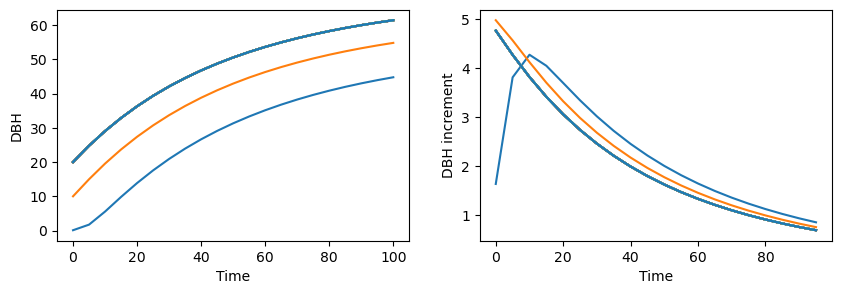

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

end_dbh, growth = pn_df.grow(DBH, SITE_INDEX, ASP, SLOPE, ELEV, 
                             CR_START, COMP_TREE_START, COMP_STAND_START, 
                             num_steps = NUM_STEPS,
                             crown_ratio_end = CR_END, 
                             comp_tree_end = COMP_TREE_END,
                             comp_stand_end = COMP_STAND_END)

dbh = jnp.insert(growth.cumsum(axis=0) + DBH, 0, DBH, axis=0)
years = np.arange(0, (NUM_STEPS+1)*5, 5)
for tree in range(dbh.shape[0]):
    ax[0].plot(years, dbh[:,tree])
    ax[1].plot(years[:-1], growth[:,tree])
ax[0].set(xlabel='Time', ylabel='DBH')
ax[1].set(xlabel='Time', ylabel='DBH increment')
plt.show()

In [10]:
CSV = '../data/interim/FIA_remeasured_trees_for_training.csv'
df = pd.read_csv(CSV)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 63 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   STATECD            290429 non-null  int64  
 1   UNITCD             290429 non-null  int64  
 2   COUNTYCD           290429 non-null  int64  
 3   PLOT               290429 non-null  int64  
 4   PLOT_ID            290429 non-null  int64  
 5   SUBPLOT            290429 non-null  int64  
 6   SUBPLOT_ID         290429 non-null  int64  
 7   PLOT_CN            290429 non-null  int64  
 8   PLOT_CN_NEXT       290429 non-null  int64  
 9   TREE_CN            220620 non-null  float64
 10  TREE_CN_NEXT       269952 non-null  float64
 11  TREE_ID            290429 non-null  int64  
 12  LAT                290429 non-null  float64
 13  LON                290429 non-null  float64
 14  ELEV               290429 non-null  float64
 15  VARIANT            290429 non-null  object 
 16  LO

In [11]:
gdf = gpd.read_file('../data/raw/FVS_Variants_and_Locations.shp')
variants = np.unique(df.VARIANT)
locations = np.sort(np.array([*set(np.unique(gdf.loc[gdf.FVSVariant.isin(variants), 'FVSLocCode'])).union(np.unique(df.LOCATION))], dtype='int'))
plots = np.unique(df.PLOT_ID)
variants, locations, plots

(array(['BM', 'CA', 'CR', 'EC', 'IE', 'NC', 'PN', 'SO', 'WC', 'WS'],
       dtype=object),
 array([103, 105, 106, 110, 113, 114, 116, 117, 118, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 224,
        301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 417,
        501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513,
        514, 515, 516, 517, 518, 601, 602, 603, 604, 605, 606, 607, 608,
        609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621,
        699, 702, 703, 705, 708, 709, 710, 711, 712, 800]),
 array([ 60101550679,  60101551744,  60101551969, ..., 530907170686,
        530907182459, 530907572668]))

In [12]:
df['VAR_IDX'], obs_variants = pd.factorize(df['VARIANT'])
df['LOC_IDX'], obs_locations = pd.factorize(df['LOCATION'])

In [13]:
df.columns

Index(['STATECD', 'UNITCD', 'COUNTYCD', 'PLOT', 'PLOT_ID', 'SUBPLOT',
       'SUBPLOT_ID', 'PLOT_CN', 'PLOT_CN_NEXT', 'TREE_CN', 'TREE_CN_NEXT',
       'TREE_ID', 'LAT', 'LON', 'ELEV', 'VARIANT', 'LOCATION', 'SLOPE',
       'ASPECT', 'TOPO_POSITION_PNW', 'MEASYEAR', 'MEASMON', 'MEASDAY',
       'MEASYEAR_NEXT', 'MEASMON_NEXT', 'MEASDAY_NEXT', 'SICOND', 'SIBASE',
       'SISP', 'SITECLCD', 'AZIMUTH', 'DISTANCE', 'STATUSCD', 'STATUSCD_NEXT',
       'MORTYR', 'MORTYR_NEXT', 'TPA_UNADJ', 'FIA_SPCD', 'FVS_ALPHA',
       'FVS_SPP', 'FVS_SPP_IDX', 'COMMON_NAME', 'DBH', 'DBH_NEXT', 'HT',
       'HT_NEXT', 'ACTUALHT', 'ACTUALHT_NEXT', 'CR', 'CR_NEXT', 'CCLCD',
       'ESTHT', 'ESTHT_NEXT', 'PTCCF', 'PTCCF_NEXT', 'PTBAPA', 'PTBAPA_NEXT',
       'DOMHT', 'RELHT', 'DOMHT_NEXT', 'RELHT_NEXT', 'BAPALARGER',
       'BAPALARGER_NEXT', 'VAR_IDX', 'LOC_IDX'],
      dtype='object')

In [14]:
RAW_COVARS = ['VAR_IDX', 'LOC_IDX',  'PLOT_ID', 'SICOND', 'ASPECT', 'SLOPE', 'ELEV',
              'DBH', 'CR', 'CR_NEXT', 'BAPALARGER', 'BAPALARGER_NEXT', 
              'PTBAPA', 'PTBAPA_NEXT']
RAW_OBS = ['DBH_NEXT']

MODEL_COVARS = ['VAR_IDX', 'LOC_IDX',  'PLOT_ID', 'SICOND', 'ASP', 'SLOPE', 'ELEV', 
               'DBH', 'CR_START', 'CR_END', 'COMP_TREE_START', 'COMP_TREE_END', 
               'COMP_STAND_START', 'COMP_STAND_END']
MODEL_OBS = ['DG_OBS']

data = df.loc[(df.FIA_SPCD == 202)&(df.STATUSCD==1)&(df.STATUSCD_NEXT==1)&((df.MEASYEAR_NEXT - df.MEASYEAR) == 10)].dropna(subset=RAW_COVARS).sample(5000)[RAW_COVARS + RAW_OBS].copy()
data[['CR_START', 'CR_END']] = data[['CR', 'CR_NEXT']] / 100.
data['COMP_TREE_START'] = data['BAPALARGER'] / np.log(data['DBH'] + 1.0)
data['COMP_TREE_END'] = data['BAPALARGER_NEXT'] / np.log(data['DBH_NEXT'] + 1.0)
data['COMP_STAND_START'] = np.log(data['PTBAPA'])
data['COMP_STAND_END'] = np.log(data['PTBAPA_NEXT'])
data['ASP'] = np.deg2rad(data['ASPECT'])
data['SLOPE'] = data['SLOPE'] / 100.
data['ELEV'] = data['ELEV'] / 100.
data['DG_OBS'] = data['DBH_NEXT'] - data['DBH']

to_model = data[MODEL_COVARS + MODEL_OBS]
to_model.describe()

VAR_IDX      LOC_IDX       PLOT_ID       SICOND          ASP  \
count  5000.000000  5000.000000  5.000000e+03  5000.000000  5000.000000   
mean      3.554400    19.419400  4.120873e+11   107.272400     3.098438   
std       1.818489    12.810305  1.345847e+11    39.923143     1.892139   
min       0.000000     0.000000  6.010155e+10    21.000000     0.000000   
25%       3.000000     8.000000  4.101040e+11    72.000000     1.483530   
50%       3.000000    22.000000  4.102020e+11   108.000000     3.228859   
75%       4.000000    29.000000  5.306028e+11   138.000000     4.712389   
max       8.000000    51.000000  5.309072e+11   223.000000     6.283185   

             SLOPE         ELEV          DBH     CR_START       CR_END  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.393518    27.600000    17.128580     0.511374     0.443760   
std       0.246246    14.368065    13.202723     0.210331     0.188928   
min       0.000000     1.000000     1.000000     0.050000     0.020000   
25%       0.200000    17.000000     7.400000     0.350000     0.300000   
50%       0.380000    29.000000    11.700000     0.450000     0.400000   
75%       0.600000    37.000000    25.400000     0.650000     0.550000   
max       1.550000    73.000000    90.700000     0.990000     0.990000   

       COMP_TREE_START  COMP_TREE_END  COMP_STAND_START  COMP_STAND_END  \
count      5000.000000    5000.000000       5000.000000     5000.000000   
mean          9.976488      11.887590          3.653543        3.959906   
std          10.636724      12.036725          0.788149        0.593118   
min           0.000000       0.000000         -0.894381        0.329905   
25%           2.478340       3.057609          3.229138        3.637637   
50%           7.215703       8.966881          3.752701        4.006906   
75%          14.399287      17.602731          4.205679        4.360393   
max         137.552025     165.146533          5.384092        5.459252   

            DG_OBS  
count  5000.000000  
mean      1.577360  
std       1.305616  
min     -12.600000  
25%       0.700000  
50%       1.300000  
75%       2.200000  
max      21.100000

In [15]:
to_model.groupby(['VAR_IDX'])['DBH'].count()

VAR_IDX
0      78
1     618
2     428
3    1780
4    1111
5      38
6     398
7     456
8      93
Name: DBH, dtype: int64

In [16]:
len(locations), len(variants)

(88, 10)

In [17]:
# diameter growth model
# original fvs (5-yr) vs refit on FIA (5-yr)
# annualize and hierarchy (for refit on FIA too?) for refitting
# switch to potential * modifier
# add climatic modifiers and compare with annualized climate-proxy version
# map climatic modifiers for several species at a snapshot in the future

In [18]:
def dg_pooled(X, num_steps, y=None, num_locations=88, num_variants=10):
    (variant, location, plot, site_index, asp, slope, elev, dbh, cr_start, cr_end, 
     comp_tree_start, comp_tree_end, comp_stand_start, comp_stand_end) = X
    
    dbh = jnp.asarray(dbh).reshape(-1,)
    num_trees = dbh.size
    location = jnp.asarray(location).reshape(-1,)
    
    plot, plot_id = pd.factorize(plot)
    num_plots = plot[-1] + 1
    
    plot = jnp.asarray(plot).reshape(-1,)
    site_index = jnp.asarray(site_index).reshape(-1,)
    asp = jnp.asarray(asp).reshape(-1,)
    slope = jnp.asarray(slope).reshape(-1,)
    elev = jnp.asarray(elev).reshape(-1,)
    
    norm = jnp.array([
        jnp.log(dbh),
        dbh**2,
        jnp.log(site_index),
        slope*jnp.cos(asp),
        slope*jnp.sin(asp),
        slope,
        slope**2,
        elev,
        elev**2,
        cr_start,
        cr_start**2,
        comp_tree_start,
        comp_stand_start
    ])
    norm_mu = norm.mean(axis=1)
    norm_sd = norm.std(axis=1)
    
    b0z = numpyro.sample('b0z', dist.Normal(0., 2.))
    b1z = numpyro.sample('b1z', dist.Normal(0., 2.))  # ln(dbh)
    b2z = numpyro.sample('b2z', dist.Normal(0., 2.))  # dbh**2
    b3z = numpyro.sample('b3z', dist.Normal(0., 2.))  # ln(site_index)
    b4z = numpyro.sample('b4z', dist.Normal(0., 2.))  # slope*cos(asp)
    b5z = numpyro.sample('b5z', dist.Normal(0., 2.))  # slope*sin(asp)
    b6z = numpyro.sample('b6z', dist.Normal(0., 2.))  # slope
    # b7z = numpyro.sample('b7z', dist.Normal(0., 2.))  # slope**2
    b8z = numpyro.sample('b8z', dist.Normal(0., 2.))  # elev
    # b9z = numpyro.sample('b9z', dist.Normal(0., 2.))  # elev**2
    b10z = numpyro.sample('b10z', dist.Normal(0., 2.))  # crown_ratio
    # b11z = numpyro.sample('b11z', dist.Normal(0., 2.))  # crown_ratio**2
    b12z = numpyro.sample('b12z', dist.Normal(0., 2.))  # comp_tree  # BAL / ln(dbh+1)
    b13z = numpyro.sample('b13z', dist.Normal(0., 2.))  # comp_stand  # ln(BA)
    
    with numpyro.plate('locations', num_locations):
        e_loc = numpyro.sample('e_loc', dist.Normal(0, 1.0)) # random effect of location
    
    if y is not None:
        with numpyro.plate('plots', num_plots):
            e_plot = numpyro.sample('e_plot', dist.Normal(0, 1.0)) # random effect of plot
    else:
        e_plot = 0 * plot
    
    b1 = numpyro.deterministic('b1', b1z/norm_sd[0])
    b2 = numpyro.deterministic('b2', b2z/norm_sd[1])
    b3 = numpyro.deterministic('b3', b3z/norm_sd[2])
    b4 = numpyro.deterministic('b4', b4z/norm_sd[3])
    b5 = numpyro.deterministic('b5', b5z/norm_sd[4])
    b6 = numpyro.deterministic('b6', b6z/norm_sd[5])
    # b7 = numpyro.deterministic('b7', b7z/norm_sd[6])
    b8 = numpyro.deterministic('b8', b8z/norm_sd[7])
    # b9 = numpyro.deterministic('b9', b9z/norm_sd[8])
    b10 = numpyro.deterministic('b10', b10z/norm_sd[9])
    # b11 = numpyro.deterministic('b11', b11z/norm_sd[10])
    b12 = numpyro.deterministic('b12', b12z/norm_sd[11])
    b13 = numpyro.deterministic('b13', b13z/norm_sd[12])
    b7, b9, b11 = 0, 0, 0
    
    adjust = (b1 + b2 + b3 + b4 + b5 + b6 + b7 + b8 + b9 + b10 + b11 + b12 + b13)
    b0 = numpyro.deterministic('b0', b0z - adjust)
    
    bark_b1 = 0.903563
    bark_b2 = 0.989388
    
    crown_ratio = jnp.linspace(cr_start, cr_end, num_steps)
    comp_tree = jnp.linspace(comp_tree_start, comp_tree_end, num_steps)
    comp_stand = jnp.linspace(comp_stand_start, comp_stand_end, num_steps)

    step_covars = crown_ratio, comp_tree, comp_stand

    def step(dbh, step_covars):
        crown_ratio, comp_tree, comp_stand = step_covars

        size = b1z * (jnp.log(dbh) - norm_mu[0])/norm_sd[0] + \
               b2z * (dbh**2 - norm_mu[1])/norm_sd[1]
        site = b3z * (jnp.log(site_index) - norm_mu[2])/norm_sd[2] + \
               b6z * (slope - norm_mu[5])/norm_sd[5] + \
               b8z * (elev - norm_mu[7])/norm_sd[7] + \
               b4z * (slope * jnp.cos(asp) - norm_mu[3])/norm_sd[3] + \
               b5z * (slope * jnp.sin(asp) - norm_mu[4])/norm_sd[4] #+ \
               # b7z * (slope**2 - norm_mu[6])/norm_sd[6] + \
               # b9z * (elev**2 - norm_mu[8])/norm_sd[8]
        comp = b10z * (crown_ratio - norm_mu[9])/norm_sd[9] + \
               b12z * (comp_tree - norm_mu[11])/norm_sd[11] + \
               b13z * (comp_stand - norm_mu[12])/norm_sd[12]
               # b11z * (crown_ratio**2 - norm_mu[10])/norm_sd[10] + \
        
        ln_dds = b0z + size + site + comp + e_loc[location] + e_plot[plot]
        dds = jnp.exp(ln_dds)
        dib_start = bark_b1*(dbh**bark_b2)
        dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
        dib_end = dib_start + dg_ib
        dbh_end = (dib_end / bark_b1)**(1/bark_b2)
        dg_ob = dbh_end - dbh
       
        return dbh_end, dg_ob

    # scan returns arrays of final dbh (shape: (1, n_trees)) 
    # and of incremental growth (shape: (n_steps, n_trees))
    dbh_end, growth = scan(step, dbh, step_covars, length=num_steps)
    dg_pred = numpyro.deterministic('dg_pred', dbh_end - dbh)
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.01, 10.0))
    with numpyro.plate('plate_obs', size=num_trees):
        obs = numpyro.sample('obs', dist.Normal(dg_pred, sigma), obs=y)

In [19]:
def dg_unpooled(X, num_steps, y=None, num_locations=88, num_variants=10):
    (variant, location, plot, site_index, asp, slope, elev, dbh, cr_start, cr_end, 
     comp_tree_start, comp_tree_end, comp_stand_start, comp_stand_end) = X
    
    dbh = jnp.asarray(dbh).reshape(-1,)
    num_trees = dbh.size
    location = jnp.asarray(location).reshape(-1,)
    
    plot, plot_id = pd.factorize(plot)
    num_plots = plot[-1] + 1
    
    plot = jnp.asarray(plot).reshape(-1,)
    site_index = jnp.asarray(site_index).reshape(-1,)
    asp = jnp.asarray(asp).reshape(-1,)
    slope = jnp.asarray(slope).reshape(-1,)
    elev = jnp.asarray(elev).reshape(-1,)
    
    norm = jnp.array([
        jnp.log(dbh),
        dbh**2,
        jnp.log(site_index),
        slope*jnp.cos(asp),
        slope*jnp.sin(asp),
        slope,
        slope**2,
        elev,
        elev**2,
        cr_start,
        cr_start**2,
        comp_tree_start,
        comp_stand_start
    ])
    norm_mu = norm.mean(axis=1)
    norm_sd = norm.std(axis=1)
    
    with numpyro.plate('variants', num_variants):
        b0z = numpyro.sample('b0z', dist.Normal(0., 2.))
        b1z = numpyro.sample('b1z', dist.Normal(0., 2.))  # ln(dbh)
        b2z = numpyro.sample('b2z', dist.Normal(0., 2.))  # dbh**2
        b3z = numpyro.sample('b3z', dist.Normal(0., 2.))  # ln(site_index)
        b4z = numpyro.sample('b4z', dist.Normal(0., 2.))  # slope*cos(asp)
        b5z = numpyro.sample('b5z', dist.Normal(0., 2.))  # slope*sin(asp)
        b6z = numpyro.sample('b6z', dist.Normal(0., 2.))  # slope
        # b7z = numpyro.sample('b7z', dist.Normal(0., 10.))  # slope**2
        b8z = numpyro.sample('b8z', dist.Normal(0., 2.))  # elev
        # b9z = numpyro.sample('b9z', dist.Normal(0., 10.))  # elev**2
        b10z = numpyro.sample('b10z', dist.Normal(0., 2.))  # crown_ratio
        # b11z = numpyro.sample('b11z', dist.Normal(0., 10.))  # crown_ratio**2
        b12z = numpyro.sample('b12z', dist.Normal(0., 2.))  # comp_tree  # BAL / ln(dbh+1)
        b13z = numpyro.sample('b13z', dist.Normal(0., 2.))  # comp_stand  # ln(BA)
    
    with numpyro.plate('locations', num_locations):
        e_loc = numpyro.sample('e_loc', dist.Normal(0, 1.0)) # random effect of location
    
    if y is not None:
        with numpyro.plate('plots', num_plots):
            e_plot = numpyro.sample('e_plot', dist.Normal(0, 1.0)) # random effect of plot
    else:
        e_plot = 0 * plot
    
    b1 = numpyro.deterministic('b1', b1z/norm_sd[0])
    b2 = numpyro.deterministic('b2', b2z/norm_sd[1])
    b3 = numpyro.deterministic('b3', b3z/norm_sd[2])
    b4 = numpyro.deterministic('b4', b4z/norm_sd[3])
    b5 = numpyro.deterministic('b5', b5z/norm_sd[4])
    b6 = numpyro.deterministic('b6', b6z/norm_sd[5])
    # b7 = numpyro.deterministic('b7', b7z/norm_sd[6])
    b8 = numpyro.deterministic('b8', b8z/norm_sd[7])
    # b9 = numpyro.deterministic('b9', b9z/norm_sd[8])
    b10 = numpyro.deterministic('b10', b10z/norm_sd[9])
    # b11 = numpyro.deterministic('b11', b11z/norm_sd[10])
    b12 = numpyro.deterministic('b12', b12z/norm_sd[11])
    b13 = numpyro.deterministic('b13', b13z/norm_sd[12])
    b7, b9, b11 = 0, 0, 0
    
    adjust = (b1 + b2 + b3 + b4 + b5 + b6 + b7 + b8 + b9 + b10 + b11 + b12 + b13)
    b0 = numpyro.deterministic('b0', b0z - adjust)
    
    bark_b1 = 0.903563
    bark_b2 = 0.989388
    
    crown_ratio = jnp.linspace(cr_start, cr_end, num_steps)
    comp_tree = jnp.linspace(comp_tree_start, comp_tree_end, num_steps)
    comp_stand = jnp.linspace(comp_stand_start, comp_stand_end, num_steps)

    step_covars = crown_ratio, comp_tree, comp_stand

    def step(dbh, step_covars):
        crown_ratio, comp_tree, comp_stand = step_covars

        size = b1z[variant] * (jnp.log(dbh) - norm_mu[0])/norm_sd[0] + \
               b2z[variant] * (dbh**2 - norm_mu[1])/norm_sd[1]
        site = b3z[variant] * (jnp.log(site_index) - norm_mu[2])/norm_sd[2] + \
               b6z[variant] * (slope - norm_mu[5])/norm_sd[5] + \
               b8z[variant] * (elev - norm_mu[7])/norm_sd[7] + \
               b4z[variant] * (slope * jnp.cos(asp) - norm_mu[3])/norm_sd[3] + \
               b5z[variant] * (slope * jnp.sin(asp) - norm_mu[4])/norm_sd[4] #+ \
               # b7z[variant] * (slope**2 - norm_mu[6])/norm_sd[6] + \
               # b9z[variant] * (elev**2 - norm_mu[8])/norm_sd[8]
        comp = b10z[variant] * (crown_ratio - norm_mu[9])/norm_sd[9] + \
               b12z[variant] * (comp_tree - norm_mu[11])/norm_sd[11] + \
               b13z[variant] * (comp_stand - norm_mu[12])/norm_sd[12]
               # b11z[variant] * (crown_ratio**2 - norm_mu[10])/norm_sd[10] + \
        
        ln_dds = b0z[variant] + size + site + comp + e_loc[location] + e_plot[plot]
        dds = jnp.exp(ln_dds)
        dib_start = bark_b1*(dbh**bark_b2)
        dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
        dib_end = dib_start + dg_ib
        dbh_end = (dib_end / bark_b1)**(1/bark_b2)
        dg_ob = dbh_end - dbh
       
        return dbh_end, dg_ob

    # scan returns arrays of final dbh (shape: (1, n_trees)) 
    # and of incremental growth (shape: (n_steps, n_trees))
    dbh_end, growth = scan(step, dbh, step_covars, length=num_steps)
    dg_pred = numpyro.deterministic('dg_pred', dbh_end - dbh)
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.01, 10.0))
    with numpyro.plate('plate_obs', size=num_trees):
        obs = numpyro.sample('obs', dist.Normal(dg_pred, sigma), obs=y)

In [20]:
def dg_partial(X, num_steps, y=None, num_locations=88, num_variants=10):
    (variant, location, plot, site_index, asp, slope, elev, dbh, cr_start, cr_end, 
     comp_tree_start, comp_tree_end, comp_stand_start, comp_stand_end) = X
    
    dbh = jnp.asarray(dbh).reshape(-1,)
    num_trees = dbh.size
    location = jnp.asarray(location).reshape(-1,)
    
    plot, plot_id = pd.factorize(plot)
    num_plots = plot[-1] + 1
    
    plot = jnp.asarray(plot).reshape(-1,)
    site_index = jnp.asarray(site_index).reshape(-1,)
    asp = jnp.asarray(asp).reshape(-1,)
    slope = jnp.asarray(slope).reshape(-1,)
    elev = jnp.asarray(elev).reshape(-1,)
    
    norm = jnp.array([
        jnp.log(dbh),
        dbh**2,
        jnp.log(site_index),
        slope*jnp.cos(asp),
        slope*jnp.sin(asp),
        slope,
        slope**2,
        elev,
        elev**2,
        cr_start,
        cr_start**2,
        comp_tree_start,
        comp_stand_start
    ])
    norm_mu = norm.mean(axis=1)
    norm_sd = norm.std(axis=1)
    
    b0z_mu = numpyro.sample('b0z_mu', dist.Normal(0., 2.))
    b0z_sd = numpyro.sample('b0z_sd', dist.InverseGamma(0.1, 0.1))
    b1z_mu = numpyro.sample('b1z_mu', dist.Normal(0., 2.))
    b1z_sd = numpyro.sample('b1z_sd', dist.InverseGamma(0.1, 0.1))
    b2z_mu = numpyro.sample('b2z_mu', dist.Normal(0., 2.))
    b2z_sd = numpyro.sample('b2z_sd', dist.InverseGamma(0.1, 0.1))
    b3z_mu = numpyro.sample('b3z_mu', dist.Normal(0., 2.))
    b3z_sd = numpyro.sample('b3z_sd', dist.InverseGamma(0.1, 0.1))
    b4z_mu = numpyro.sample('b4z_mu', dist.Normal(0., 2.))
    b4z_sd = numpyro.sample('b4z_sd', dist.InverseGamma(0.1, 0.1))
    b5z_mu = numpyro.sample('b5z_mu', dist.Normal(0., 2.))
    b5z_sd = numpyro.sample('b5z_sd', dist.InverseGamma(0.1, 0.1))
    b6z_mu = numpyro.sample('b6z_mu', dist.Normal(0., 2.))
    b6z_sd = numpyro.sample('b6z_sd', dist.InverseGamma(0.1, 0.1))
    # b7z_mu = numpyro.sample('b7z_mu', dist.Normal(0., 2.))
    # b7z_sd = numpyro.sample('b7z_sd', dist.InverseGamma(0.1, 0.1))
    b8z_mu = numpyro.sample('b8z_mu', dist.Normal(0., 2.))
    b8z_sd = numpyro.sample('b8z_sd', dist.InverseGamma(0.1, 0.1))
    # b9z_mu = numpyro.sample('b9z_mu', dist.Normal(0., 10.))
    # b9z_sd = numpyro.sample('b9z_sd', dist.InverseGamma(0.1, 0.1))
    b10z_mu = numpyro.sample('b10z_mu', dist.Normal(0., 2.))
    b10z_sd = numpyro.sample('b10z_sd', dist.InverseGamma(0.1, 0.1))
    # b11z_mu = numpyro.sample('b11z_mu', dist.Normal(0., 10.))
    # b11z_sd = numpyro.sample('b11z_sd', dist.InverseGamma(0.1, 0.1))
    b12z_mu = numpyro.sample('b12z_mu', dist.Normal(0., 2.))
    b12z_sd = numpyro.sample('b12z_sd', dist.InverseGamma(0.1, 0.1))
    b13z_mu = numpyro.sample('b13z_mu', dist.Normal(0., 2.))
    b13z_sd = numpyro.sample('b13z_sd', dist.InverseGamma(0.1, 0.1))
    
    with numpyro.plate('variants', num_variants):
        b0z = numpyro.sample('b0z', dist.Normal(b0z_mu, b0z_sd))
        b1z = numpyro.sample('b1z', dist.Normal(b1z_mu, b1z_sd))  # ln(dbh)
        b2z = numpyro.sample('b2z', dist.Normal(b2z_mu, b2z_sd))  # dbh**2
        b3z = numpyro.sample('b3z', dist.Normal(b3z_mu, b3z_sd))  # ln(site_index)
        b4z = numpyro.sample('b4z', dist.Normal(b4z_mu, b4z_sd))  # slope*cos(asp)
        b5z = numpyro.sample('b5z', dist.Normal(b5z_mu, b5z_sd))  # slope*sin(asp)
        b6z = numpyro.sample('b6z', dist.Normal(b6z_mu, b6z_sd))  # slope
        # b7z = numpyro.sample('b7z', dist.Normal(b7z_mu, b7z_sd))  # slope**2
        b8z = numpyro.sample('b8z', dist.Normal(b8z_mu, b8z_sd))  # elev
        # b9z = numpyro.sample('b9z', dist.Normal(b9z_mu, b9z_sd))  # elev**2
        b10z = numpyro.sample('b10z', dist.Normal(b10z_mu, b10z_sd))  # crown_ratio
        # b11z = numpyro.sample('b11z', dist.Normal(b11z_mu, b11z_sd))  # crown_ratio**2
        b12z = numpyro.sample('b12z', dist.Normal(b12z_mu, b12z_sd))  # comp_tree  # BAL / ln(dbh+1)
        b13z = numpyro.sample('b13z', dist.Normal(b13z_mu, b13z_sd))  # comp_stand  # ln(BA)
    
    with numpyro.plate('locations', num_locations):
        e_loc = numpyro.sample('e_loc', dist.Normal(0, 0.1)) # random effect of location
    
    if y is not None:
        with numpyro.plate('plots', num_plots):
            e_plot = numpyro.sample('e_plot', dist.Normal(0, 0.1)) # random effect of plot
    else:
        e_plot = 0 * plot
    
    b1 = numpyro.deterministic('b1', b1z/norm_sd[0])
    b2 = numpyro.deterministic('b2', b2z/norm_sd[1])
    b3 = numpyro.deterministic('b3', b3z/norm_sd[2])
    b4 = numpyro.deterministic('b4', b4z/norm_sd[3])
    b5 = numpyro.deterministic('b5', b5z/norm_sd[4])
    b6 = numpyro.deterministic('b6', b6z/norm_sd[5])
    # b7 = numpyro.deterministic('b7', b7z/norm_sd[6])
    b8 = numpyro.deterministic('b8', b8z/norm_sd[7])
    # b9 = numpyro.deterministic('b9', b9z/norm_sd[8])
    b10 = numpyro.deterministic('b10', b10z/norm_sd[9])
    # b11 = numpyro.deterministic('b11', b11z/norm_sd[10])
    b12 = numpyro.deterministic('b12', b12z/norm_sd[11])
    b13 = numpyro.deterministic('b13', b13z/norm_sd[12])
    b7, b9, b11 = 0, 0, 0
    
    adjust = (b1 + b2 + b3 + b4 + b5 + b6 + b7 + b8 + b9 + b10 + b11 + b12 + b13)
    b0 = numpyro.deterministic('b0', b0z - adjust)
    
    bark_b1 = 0.903563
    bark_b2 = 0.989388
    
    crown_ratio = jnp.linspace(cr_start, cr_end, num_steps)
    comp_tree = jnp.linspace(comp_tree_start, comp_tree_end, num_steps)
    comp_stand = jnp.linspace(comp_stand_start, comp_stand_end, num_steps)

    step_covars = crown_ratio, comp_tree, comp_stand

    def step(dbh, step_covars):
        crown_ratio, comp_tree, comp_stand = step_covars

        size = b1z[variant] * (jnp.log(dbh) - norm_mu[0])/norm_sd[0] + \
               b2z[variant] * (dbh**2 - norm_mu[1])/norm_sd[1]
        site = b3z[variant] * (jnp.log(site_index) - norm_mu[2])/norm_sd[2] + \
               b6z[variant] * (slope - norm_mu[5])/norm_sd[5] + \
               b8z[variant] * (elev - norm_mu[7])/norm_sd[7] + \
               b4z[variant] * (slope * jnp.cos(asp) - norm_mu[3])/norm_sd[3] + \
               b5z[variant] * (slope * jnp.sin(asp) - norm_mu[4])/norm_sd[4] #+ \
               # b7z[variant] * (slope**2 - norm_mu[6])/norm_sd[6] + \
               # b9z[variant] * (elev**2 - norm_mu[8])/norm_sd[8]
        comp = b10z[variant] * (crown_ratio - norm_mu[9])/norm_sd[9] + \
               b12z[variant] * (comp_tree - norm_mu[11])/norm_sd[11] + \
               b13z[variant] * (comp_stand - norm_mu[12])/norm_sd[12]
               # b11z[variant] * (crown_ratio**2 - norm_mu[10])/norm_sd[10] + \
        
        ln_dds = b0z[variant] + size + site + comp + e_loc[location] + e_plot[plot]
        dds = jnp.exp(ln_dds)
        dib_start = bark_b1*(dbh**bark_b2)
        dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
        dib_end = dib_start + dg_ib
        dbh_end = (dib_end / bark_b1)**(1/bark_b2)
        dg_ob = dbh_end - dbh
       
        return dbh_end, dg_ob

    # scan returns arrays of final dbh (shape: (1, n_trees)) 
    # and of incremental growth (shape: (n_steps, n_trees))
    dbh_end, growth = scan(step, dbh, step_covars, length=num_steps)
    dg_pred = numpyro.deterministic('dg_pred', dbh_end - dbh)
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.01, 10.0))
    with numpyro.plate('plate_obs', size=num_trees):
        obs = numpyro.sample('obs', dist.Normal(dg_pred, sigma), obs=y)

In [21]:
def run_inference(rng_key, 
                  model=dg_pooled, data_to_model=to_model, decenter=False, num_steps=10,
                  num_chains=3, num_warmup=1000, num_samples=1000,
                  progress_bar=True):
    
    if decenter:
        # LocScaleReparam with centered=0 fully "decenters" the prior over betas.
        config = {f"b{i}z": LocScaleReparam(centered=0) for i in range(14)}
        # The coordinate system of this model is equivalent to that in _rep_hs_model1 above.
        decentered_model = numpyro.handlers.reparam(model, config=config)
        kernel = NUTS(decentered_model, init_strategy=init_to_feasible)
    else:
        kernel = NUTS(model, init_strategy=init_to_feasible)
        

    mcmc = MCMC(kernel, 
                num_chains=num_chains,
                num_warmup=num_warmup, 
                num_samples=num_samples, 
                progress_bar=progress_bar,
               )
    
    mcmc.run(rng_key,
             X=[data_to_model[col].values for col in MODEL_COVARS],
             num_steps=num_steps,
             y=data['DG_OBS'].values,
            )
    
    mcmc.print_summary()
    return mcmc

In [22]:
pooled = run_inference(random.PRNGKey(42), 
                       model=dg_pooled, 
                       data_to_model=to_model,
                       num_warmup=1500, 
                       num_samples=2000,
                       decenter=True)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0z_decentered      0.43      0.08      0.42      0.29      0.56    423.92      1.02
  b10z_decentered      0.16      0.01      0.16      0.15      0.18   2007.39      1.00
  b12z_decentered     -0.31      0.01     -0.31     -0.33     -0.29   2493.18      1.00
  b13z_decentered      0.11      0.01      0.11      0.09      0.13   2137.37      1.00
   b1z_decentered      0.26      0.02      0.26      0.23      0.29   1718.49      1.00
   b2z_decentered     -0.08      0.01     -0.08     -0.10     -0.06   2721.31      1.00
   b3z_decentered      0.19      0.02      0.19      0.16      0.22    818.20      1.00
   b4z_decentered     -0.01      0.01     -0.01     -0.03      0.01   1047.30      1.00
   b5z_decentered     -0.00      0.01     -0.00     -0.02      0.02    833.22      1.00
   b6z_decentered     -0.03      0.01     -0.03     -0.05     -0.01    745.93      1.00
   b8z_decentered     -0.04    

In [23]:
unpooled = run_inference(random.PRNGKey(42),
                         model=dg_unpooled, 
                         data_to_model=to_model, 
                         num_warmup=1500, 
                         num_samples=2000,
                         decenter=True)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
 b0z_decentered[0]      0.17      0.24      0.17     -0.22      0.57   1124.01      1.00
 b0z_decentered[1]      0.35      0.12      0.35      0.15      0.55    506.41      1.00
 b0z_decentered[2]      0.24      0.26      0.24     -0.17      0.68   1036.47      1.00
 b0z_decentered[3]      0.35      0.10      0.35      0.17      0.51    464.66      1.00
 b0z_decentered[4]      0.38      0.14      0.38      0.17      0.62    440.21      1.00
 b0z_decentered[5]      0.33      0.46      0.34     -0.44      1.05   1803.96      1.00
 b0z_decentered[6]      0.42      0.14      0.42      0.18      0.64    506.09      1.00
 b0z_decentered[7]      0.36      0.15      0.36      0.11      0.59    515.76      1.00
 b0z_decentered[8]      0.74      0.30      0.74      0.28      1.26   1431.75      1.00
 b0z_decentered[9]      0.02      0.98      0.02     -1.58      1.66   6254.05      1.00
b10z_decentered[0]  

In [24]:
partial_pooled = run_inference(random.PRNGKey(42),
                               model=dg_partial, 
                               data_to_model=to_model, 
                               num_warmup=1500, 
                               num_samples=2000,
                               decenter=True)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
 b0z_decentered[0]     -1.08      0.59     -1.06     -2.03     -0.14   5530.96      1.00
 b0z_decentered[1]     -0.39      0.44     -0.38     -1.11      0.32   4040.94      1.00
 b0z_decentered[2]     -0.90      0.56     -0.87     -1.80      0.00   5069.98      1.00
 b0z_decentered[3]     -0.65      0.43     -0.63     -1.35      0.04   3539.52      1.00
 b0z_decentered[4]      0.03      0.42      0.03     -0.69      0.70   3702.08      1.00
 b0z_decentered[5]      0.17      0.67      0.18     -0.86      1.36   7121.95      1.00
 b0z_decentered[6]      0.58      0.45      0.57     -0.18      1.30   4172.25      1.00
 b0z_decentered[7]      0.58      0.44      0.56     -0.17      1.27   4017.51      1.00
 b0z_decentered[8]      1.66      0.62      1.63      0.62      2.65   5494.68      1.00
 b0z_decentered[9]     -0.01      0.97     -0.02     -1.57      1.63  11831.05      1.00
            b0z_mu  

In [25]:
pooled_result = az.from_numpyro(pooled)
unpooled_result = az.from_numpyro(unpooled)
partial_result = az.from_numpyro(partial_pooled)

In [26]:
az.loo(pooled_result), az.loo(unpooled_result), az.loo(partial_result), 

/opt/miniconda3/envs/refit_fvs/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/miniconda3/envs/refit_fvs/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/miniconda3/envs/refit_fvs/lib/python3.10/si

(Computed from 6000 posterior samples and 5000 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -6456.40   235.35
 p_loo     1686.88        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)     2866   57.3%
  (0.5, 0.7]   (ok)        941   18.8%
    (0.7, 1]   (bad)       921   18.4%
    (1, Inf)   (very bad)  272    5.4%,
 Computed from 6000 posterior samples and 5000 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -6343.11   219.84
 p_loo     1743.90        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)     2774   55.5%
  (0.5, 0.7]   (ok)        989   19.8%
    (0.7, 1]   (bad)       933   18.7%
    (1, Inf)   (very bad)  304    6.1%,
 Computed from 6000 posterior sample

In [27]:
az.waic(pooled_result), az.waic(unpooled_result), az.waic(partial_result), 

/opt/miniconda3/envs/refit_fvs/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/miniconda3/envs/refit_fvs/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/miniconda3/envs/refit_fvs/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


(Computed from 6000 posterior samples and 5000 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic -6220.64   262.58
 p_waic     1451.11        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 6000 posterior samples and 5000 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic -6049.92   228.85
 p_waic     1450.71        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 6000 posterior samples and 5000 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic -6345.15   306.79
 p_waic      529.98        -
 
 There has been a warning during the calculation. Please check the results.)

In [28]:
DISPLAY_PARAMS = ['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', #'b7', 
                  'b8', #'b9', 
                  'b10', #'b11', 
                  'b12', 'b13', 'sigma', 'e_loc', 'e_plot']
# DISPLAY_PARAMS = ['b0', 'b1z', 'b2z', 'b3z', 'b4z', 'b5z', 'b6z', 'b7z', 'b8z', 'b9z', 'b10z', 'b11z', 'b12z', 'b13z', 'sigma']

DISPLAY_NAMES = ['variant_intercept', 'lnDBH', 'DBH**2', 'lnSI', 'SLOPE*cos(ASP)', 'SLOPE*sin(ASP)', 
                 'SLOPE', #'SLOPE**2', 
                 'ELEV', # 'ELEV**2', 
                 'CR', # 'CR**2', 
                 'COMP_TREE', 'COMP_STAND', 'variability', 'location', 'plot']

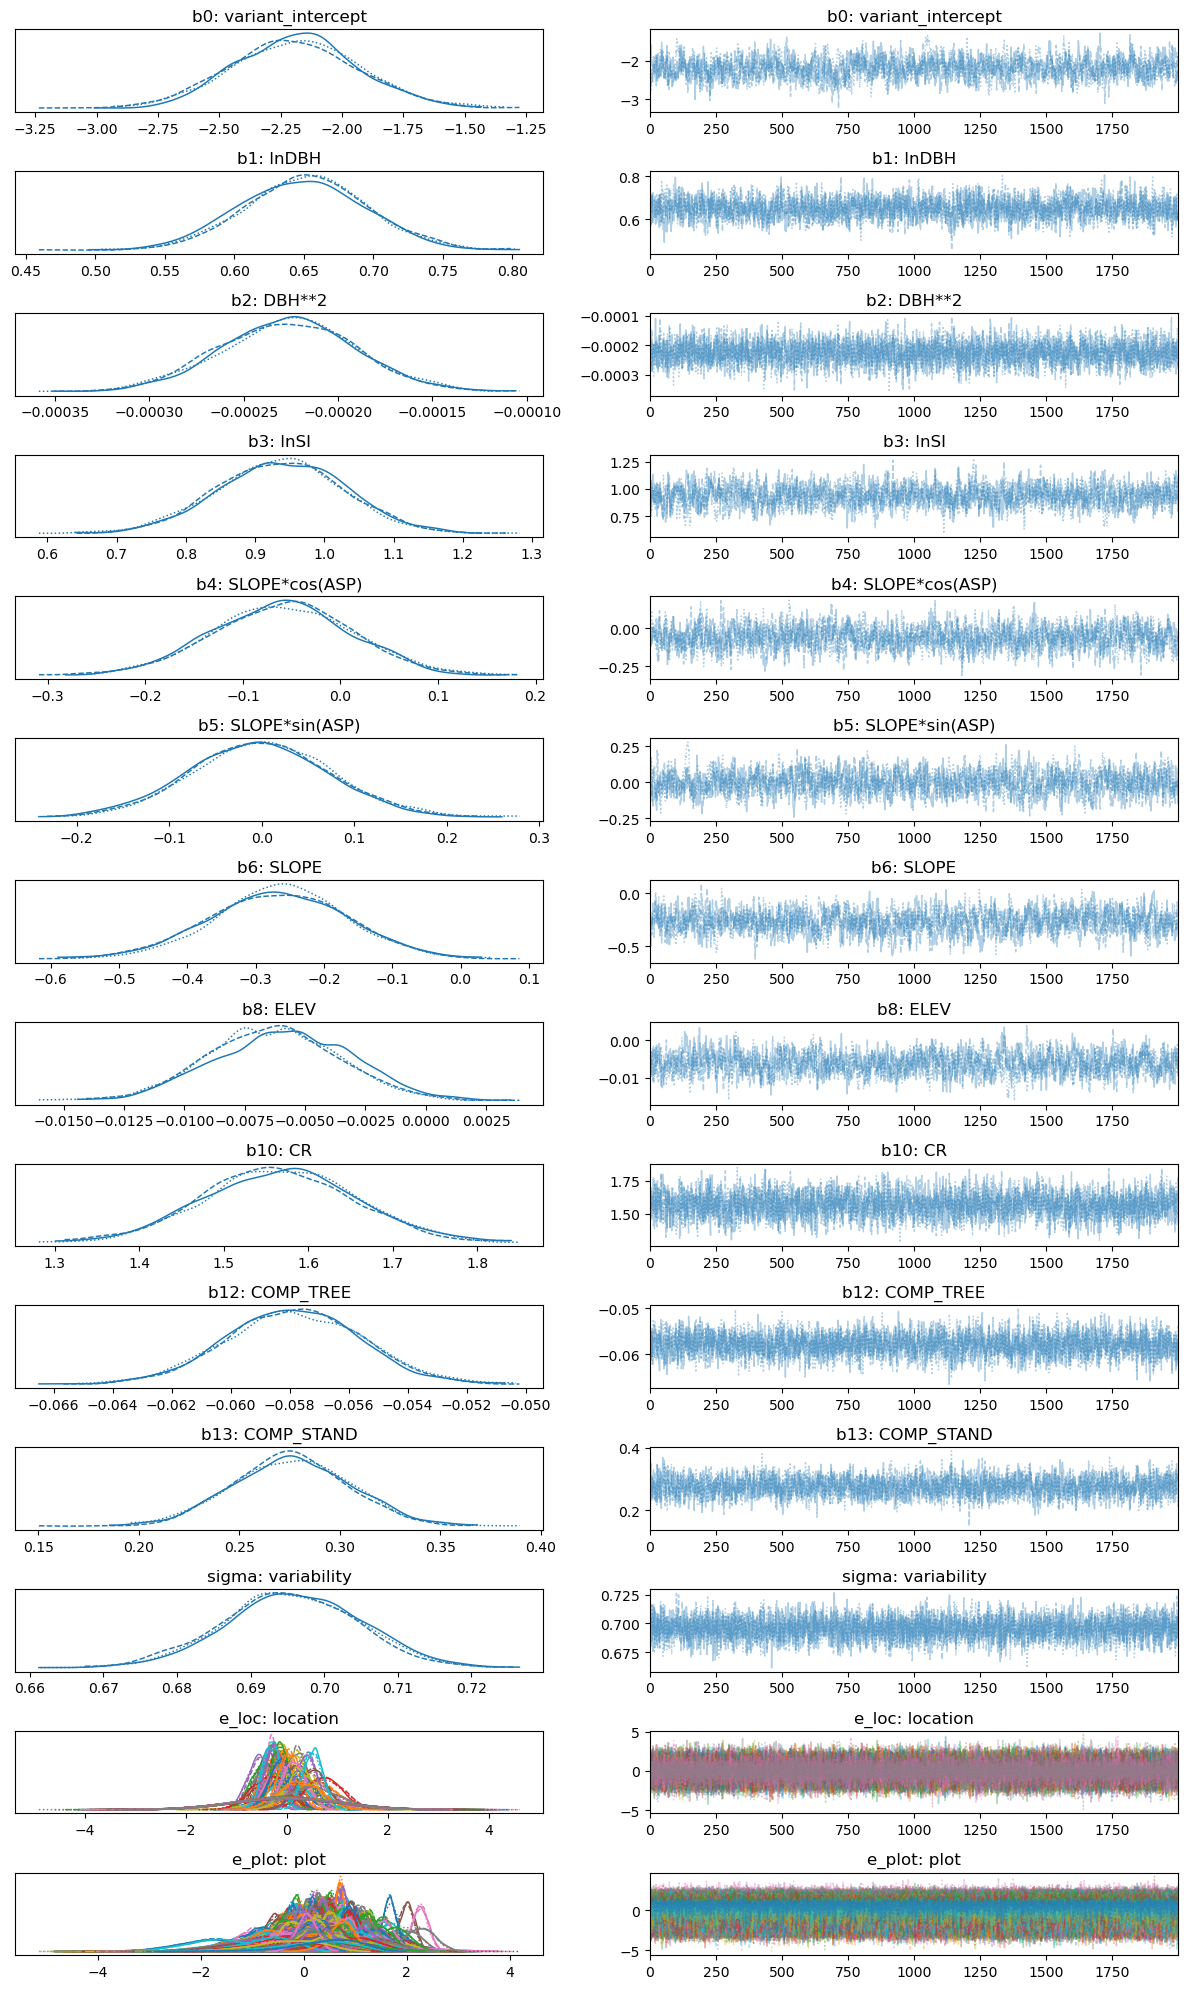

In [29]:
fig, axs = plt.subplots(14, 2, figsize=(12,20))
az.plot_trace(pooled_result, var_names=DISPLAY_PARAMS, 
              axes=axs)
for i, p in enumerate(DISPLAY_PARAMS):
    for ax in axs[i,:]:
        ax.set_title(f'{p}: {DISPLAY_NAMES[i]}')
plt.tight_layout()
plt.show()

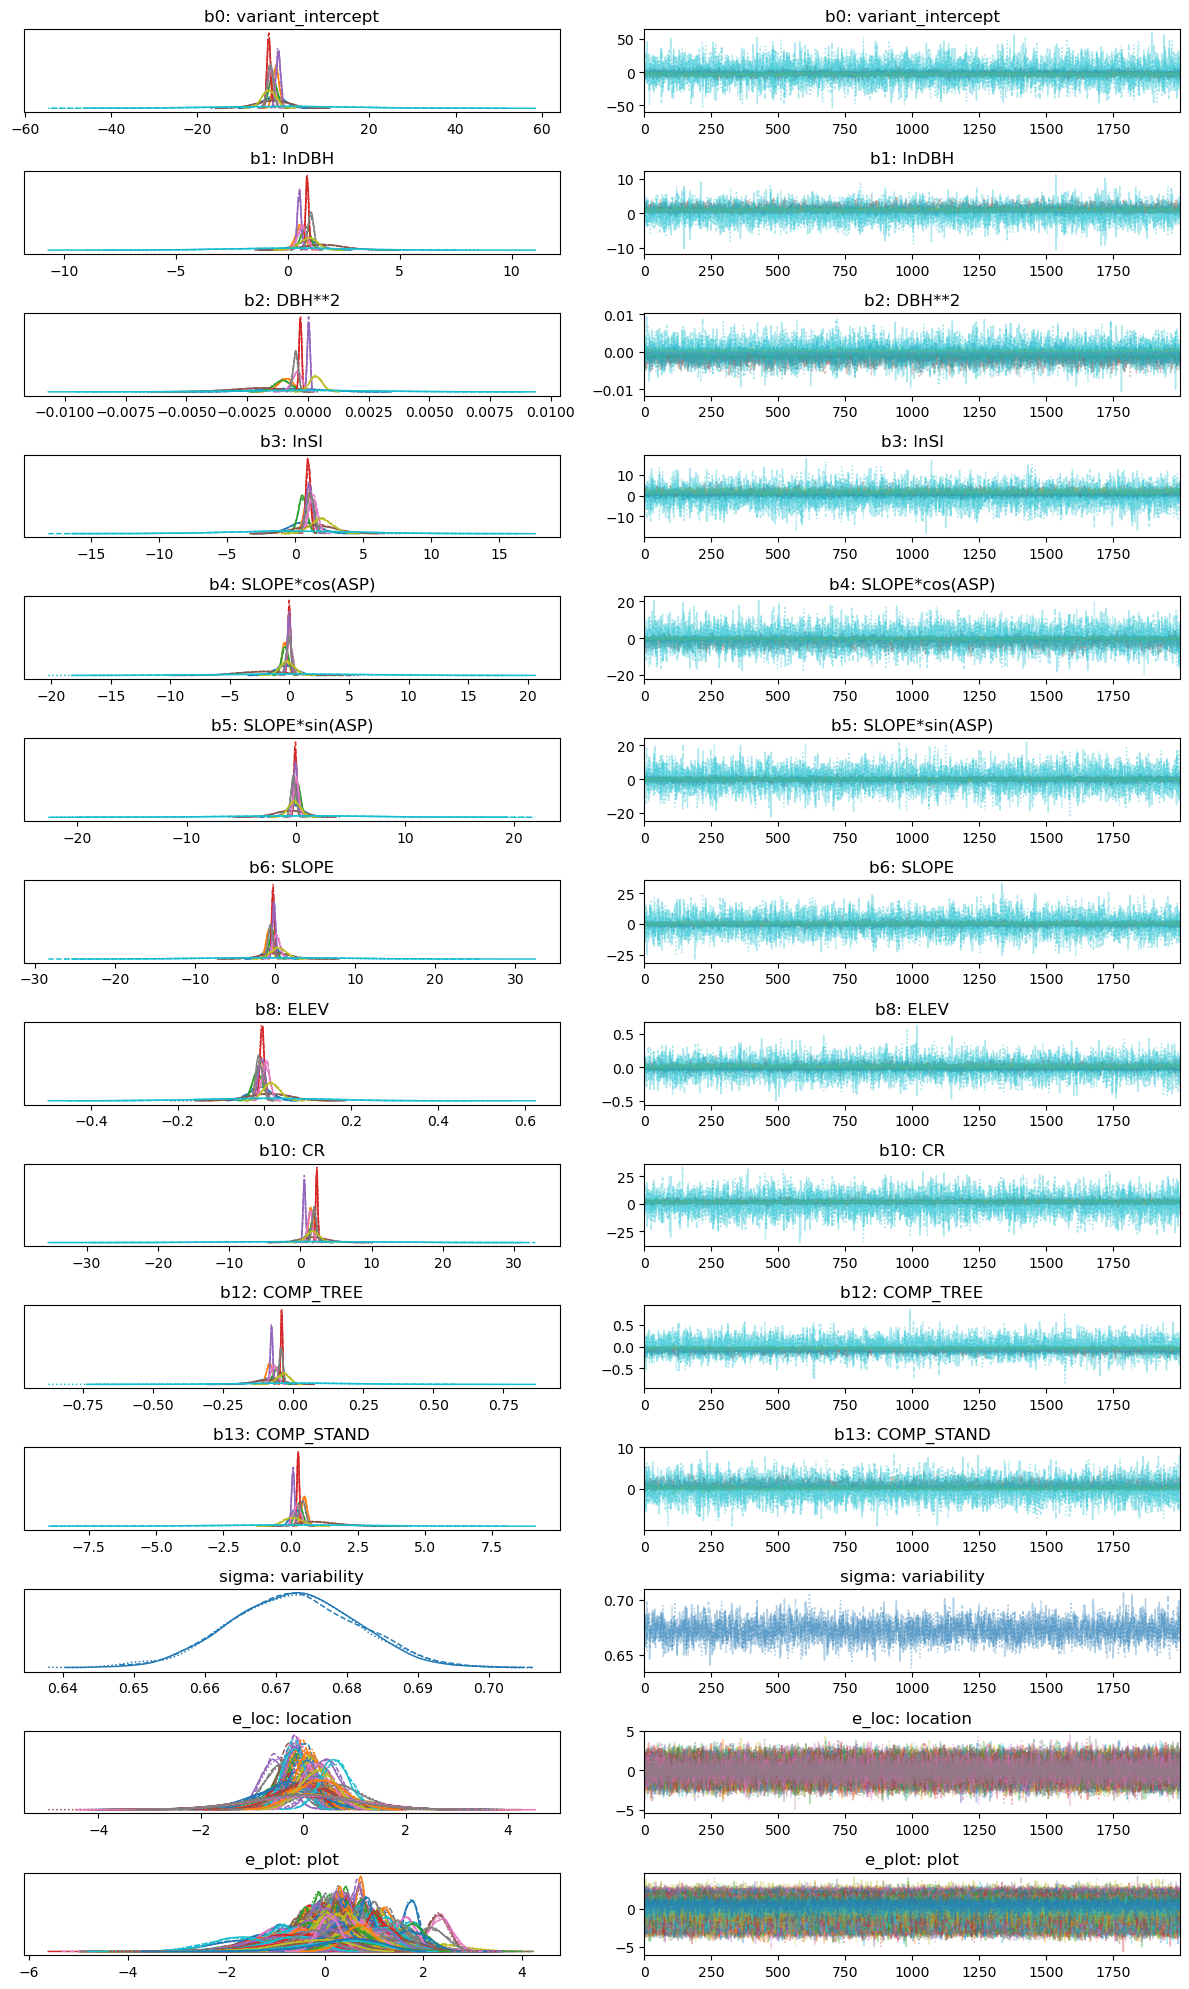

In [30]:
fig, axs = plt.subplots(14, 2, figsize=(12,20))
az.plot_trace(unpooled_result, var_names=DISPLAY_PARAMS, 
              axes=axs)
for i, p in enumerate(DISPLAY_PARAMS):
    for ax in axs[i,:]:
        ax.set_title(f'{p}: {DISPLAY_NAMES[i]}')
plt.tight_layout()
plt.show()

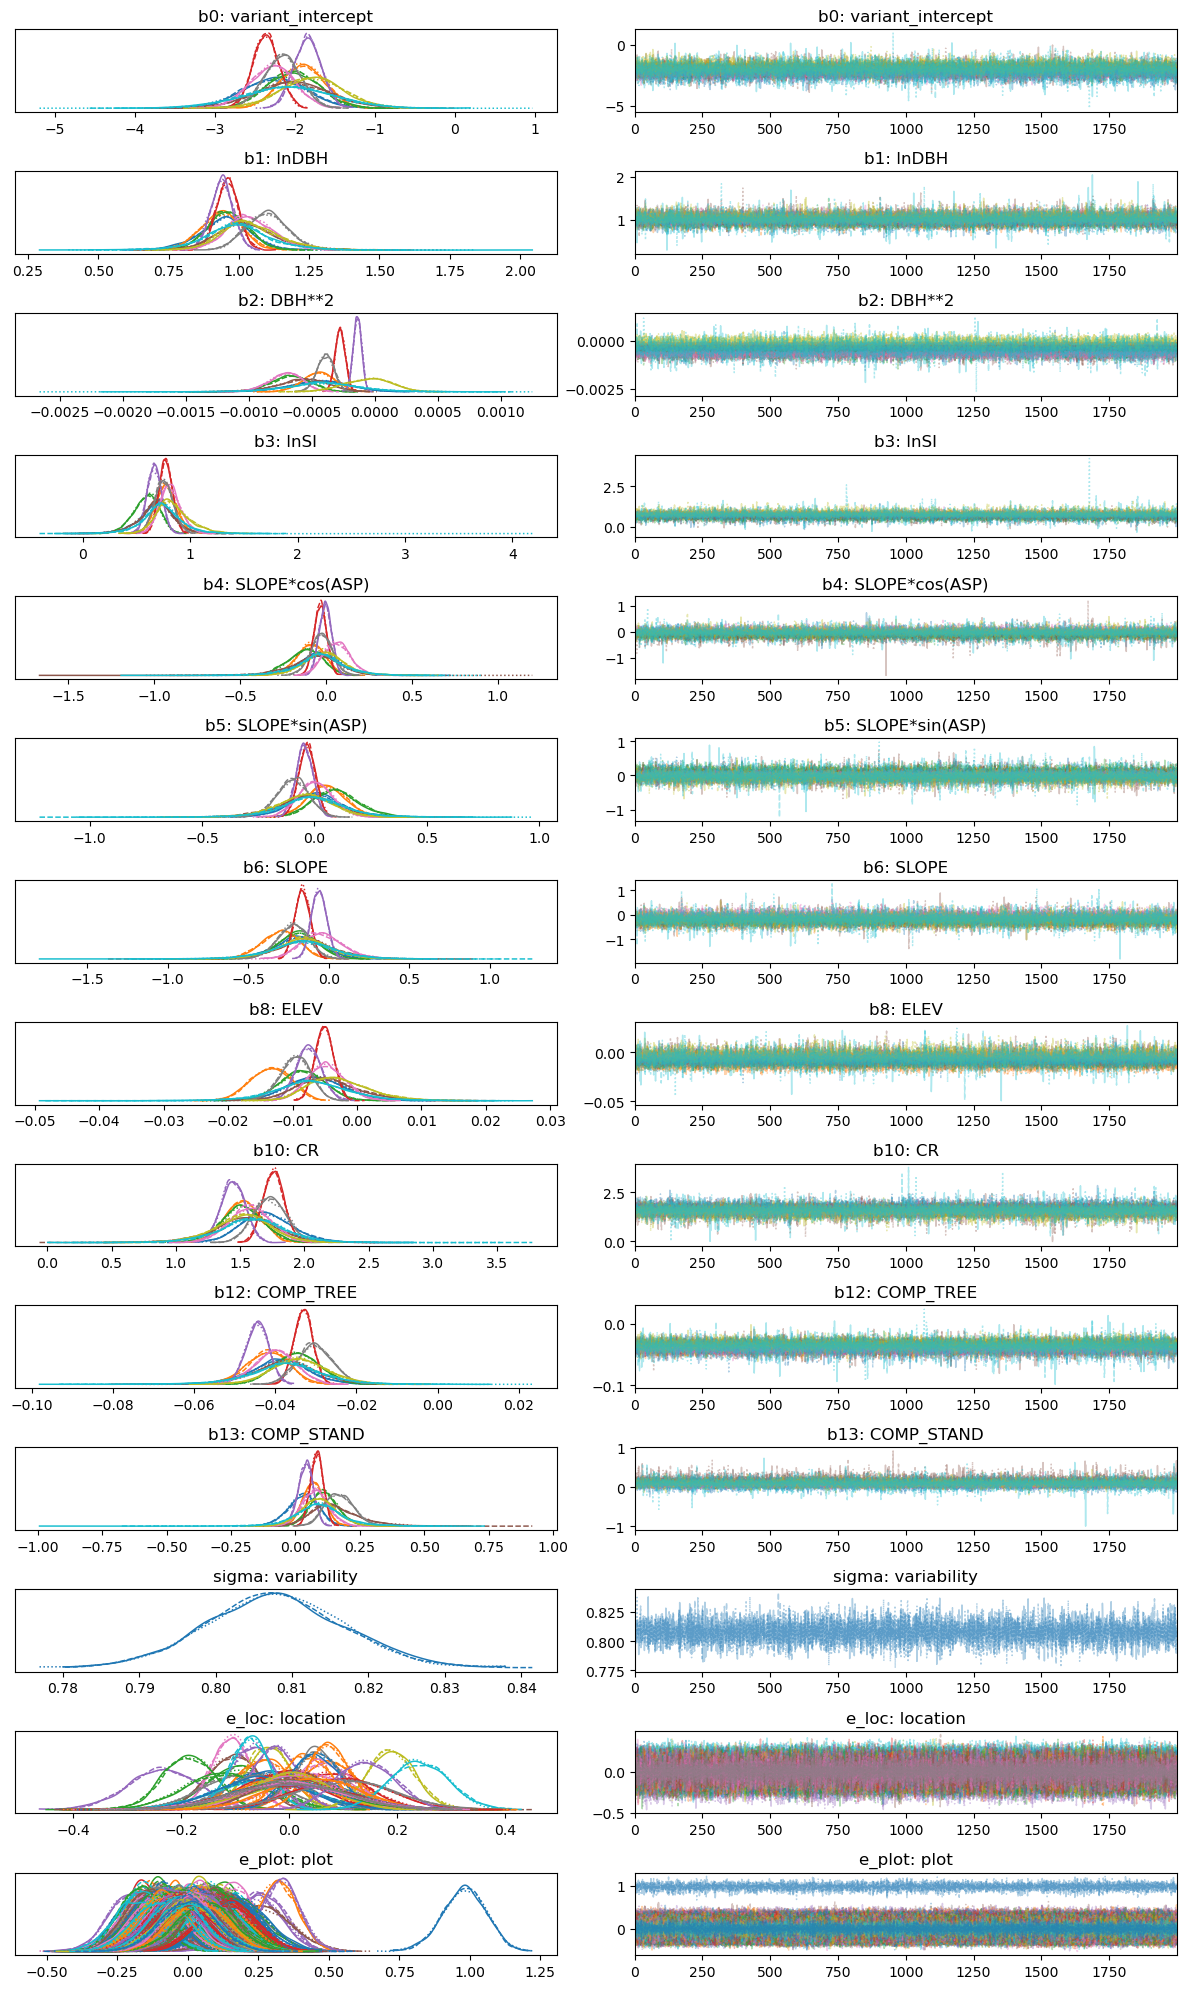

In [31]:
fig, axs = plt.subplots(14, 2, figsize=(12,20))
az.plot_trace(partial_result, var_names=DISPLAY_PARAMS, 
              axes=axs)
for i, p in enumerate(DISPLAY_PARAMS):
    for ax in axs[i,:]:
        ax.set_title(f'{p}: {DISPLAY_NAMES[i]}')
plt.tight_layout()
plt.show()

In [32]:
pooled_samples = pooled.get_samples()
unpooled_samples = unpooled.get_samples()
partial_samples = partial_pooled.get_samples()

pooled_posterior = Predictive(dg_pooled, posterior_samples=pooled_samples)
unpooled_posterior = Predictive(dg_unpooled, posterior_samples=unpooled_samples)
partial_posterior = Predictive(dg_partial, posterior_samples=partial_samples)

In [33]:
rng_key = random.PRNGKey(3)
sorted_data = to_model.sort_values(by=['DG_OBS'])

pooled_pred = pooled_posterior(
    rng_key, 
    X=tuple(sorted_data[col].values for col in MODEL_COVARS),
    num_steps=10,
    y=None
)
unpooled_pred = unpooled_posterior(
    rng_key, 
    X=tuple(sorted_data[col].values for col in MODEL_COVARS),
    num_steps=10,
    y=None
)
partial_pred = partial_posterior(
    rng_key, 
    X=tuple(sorted_data[col].values for col in MODEL_COVARS),
    num_steps=10,
    y=None
)


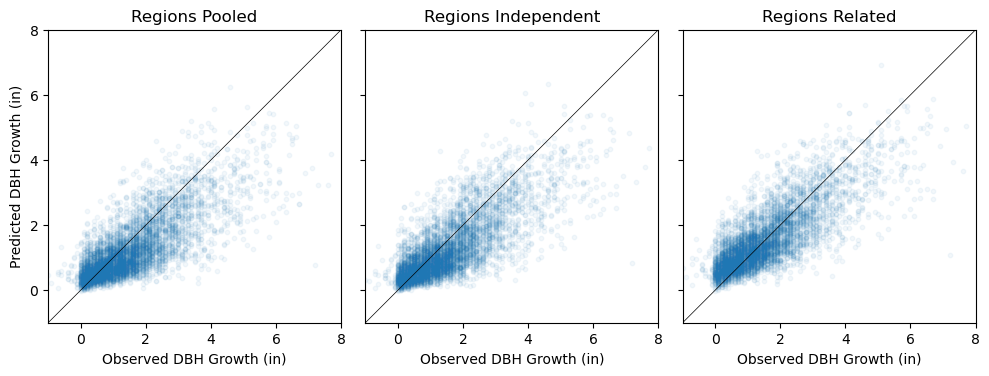

In [34]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,5))
axs[0].scatter(sorted_data['DG_OBS'].values, pooled_pred['obs'].mean(axis=0), s=10.0, alpha=0.05)
axs[1].scatter(sorted_data['DG_OBS'].values, unpooled_pred['obs'].mean(axis=0), s=10.0, alpha=0.05)
axs[2].scatter(sorted_data['DG_OBS'].values, partial_pred['obs'].mean(axis=0), s=10.0, alpha=0.05)

for ax in axs:
    ax.plot([-1,8], [-1,8], color='black', lw=0.5)
    ax.set(ylim=(-1,8), xlim=(-1,8), aspect='equal', xticks=[0,2,4,6,8], yticks=[0,2,4,6,8])
    ax.set(xlabel='Observed DBH Growth (in)')
axs[0].set(ylabel='Predicted DBH Growth (in)')
axs[0].set_title('Regions Pooled')
axs[1].set_title('Regions Independent')
axs[2].set_title('Regions Related')
plt.tight_layout()
plt.show()

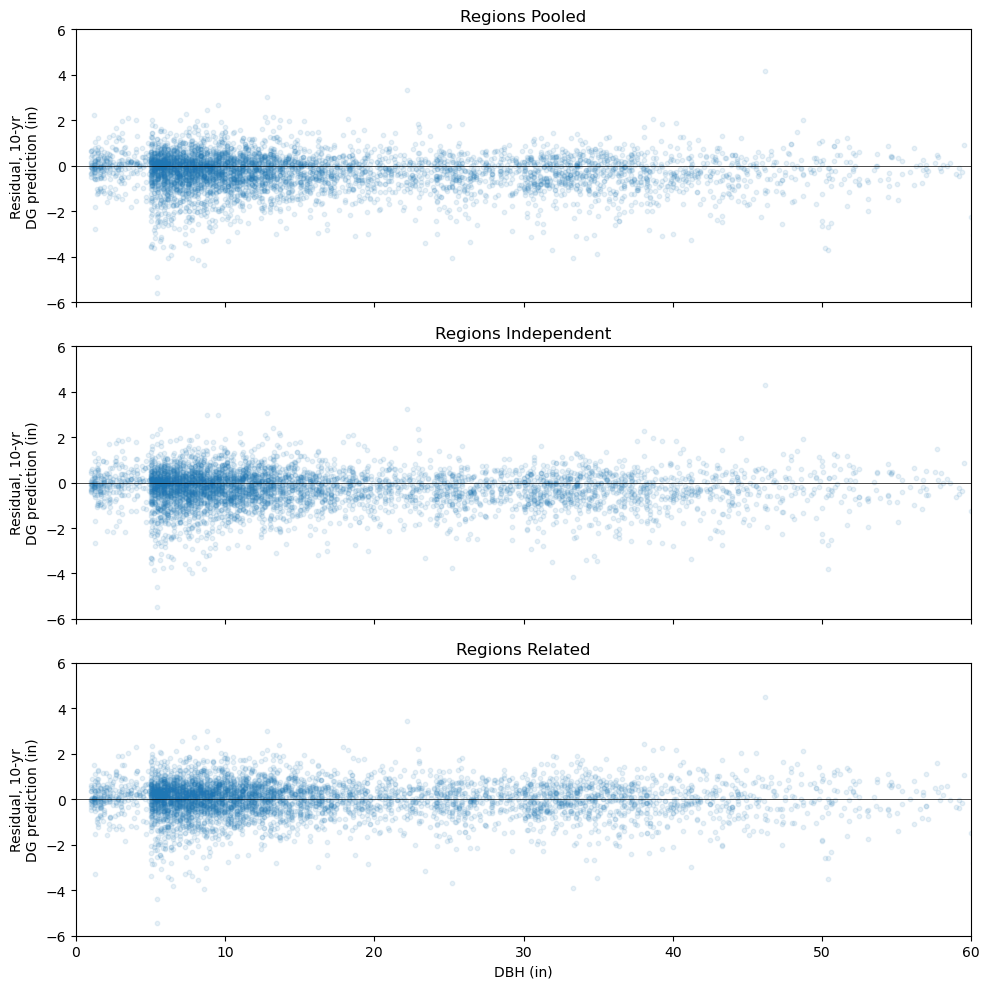

In [35]:
fig, axs = plt.subplots(3,1, figsize=(10,10), sharex=True, sharey=True)
d_sort = sorted_data.reset_index(drop=True).sort_values(by=['DBH']).index.values
resid_pooled = pooled_pred['obs'][:,d_sort] - sorted_data['DG_OBS'].values[d_sort]
resid_unpooled = unpooled_pred['obs'][:,d_sort] - sorted_data['DG_OBS'].values[d_sort]
resid_partial = partial_pred['obs'][:,d_sort] - sorted_data['DG_OBS'].values[d_sort]

axs[0].scatter(sorted_data['DBH'].values[d_sort], resid_pooled.mean(axis=0), s=10.0, alpha=0.1)
axs[1].scatter(sorted_data['DBH'].values[d_sort], resid_unpooled.mean(axis=0), s=10.0, alpha=0.1)
axs[2].scatter(sorted_data['DBH'].values[d_sort], resid_partial.mean(axis=0), s=10.0, alpha=0.1)

for ax in axs:
    ax.axhline(0, lw=0.5, color='black')
    ax.set(ylim=(-6,6), xlim=(0,60),
       ylabel='Residual, 10-yr\nDG prediction (in)'
      )
axs[-1].set_xlabel('DBH (in)')
axs[0].set_title('Regions Pooled')
axs[1].set_title('Regions Independent')
axs[2].set_title('Regions Related')
plt.tight_layout()
plt.show()